In [1]:
import mlx.core as mx
import mlx.nn as nn
from mlx.data import datasets
import mlx.optimizers as optim
import numpy as np
import time
from functools import partial

In [2]:
# Import local module
from datasets_utils import cifar10

cifar10_train = datasets.load_cifar10(train=True)
cifar10_test = datasets.load_cifar10(train=False)

len(cifar10_train), len(cifar10_test)

(50000, 10000)

In [3]:
def get_streamed_data(data, batch_size=0, shuffled=True):
    mean = np.array([0.485, 0.456, 0.406]).reshape((1, 1, 3))
    std = np.array([0.229, 0.224, 0.225]).reshape((1, 1, 3))

    def normalize(x):
        x = x.astype("float32") / 255.0
        return (x - mean) / std

    buffer = data.shuffle() if shuffled else data
    stream = buffer.to_stream()
    stream = stream.key_transform("image", normalize)
    stream = stream.batch(batch_size) if batch_size > 0 else stream
    return stream.prefetch(4, 2)

In [4]:
mx.random.seed(42)
stream = get_streamed_data(cifar10_train, batch_size=1, shuffled=True)
batch = next(stream)
X, y = mx.array(batch["image"]), mx.array(batch["label"])
X.shape, y.shape

((1, 32, 32, 3), (1,))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

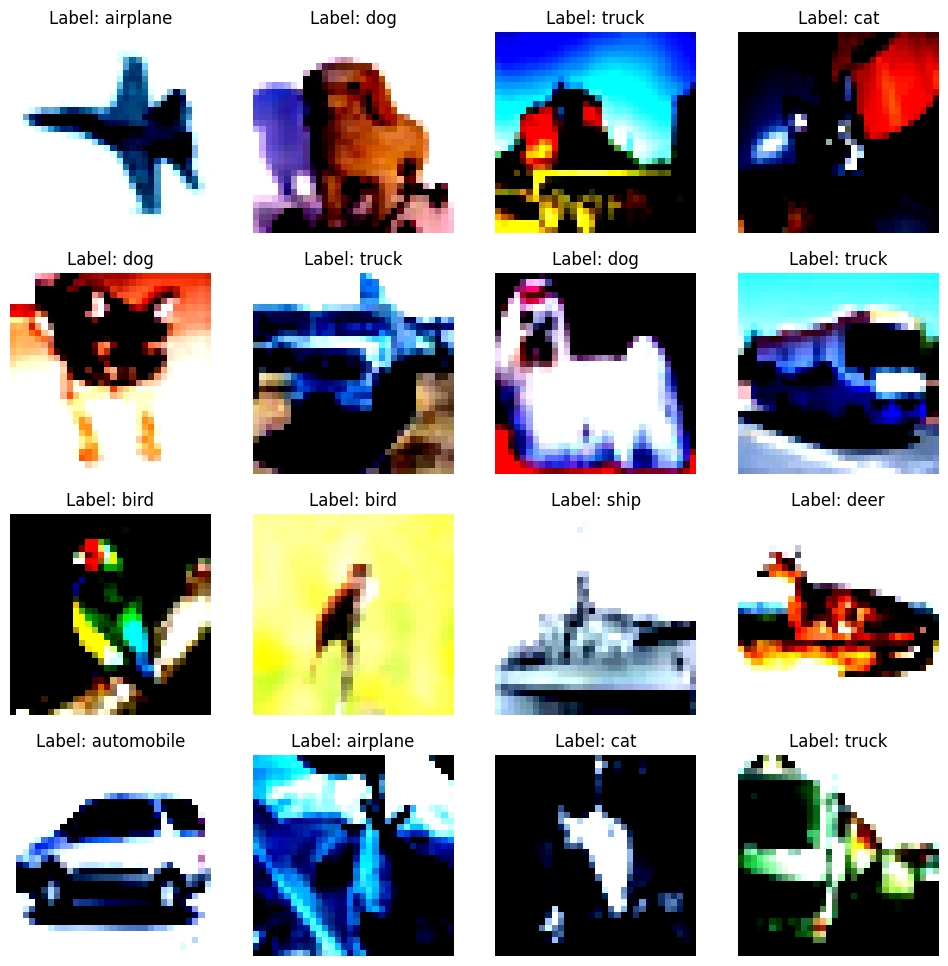

In [5]:
import matplotlib.pyplot as plt
# Visualize image samples
mx.random.seed(42)

n_cols = 4
n_rows = 4
fig = plt.figure(figsize=(12, 12))
for i, batch in zip(range(n_cols * n_rows), stream):    
    ax = fig.add_subplot(n_rows, n_cols, i+1)
    img = mx.array(batch["image"])
    label = batch["label"].squeeze()
    label = cifar10.labels[label]
    img = img.astype(mx.float32)
    ax.set_title(f"Label: {label}")
    ax.set_axis_off()
    ax.imshow(img.squeeze())
plt.show()

In [6]:
# Adopt TinyVGG architecture, but in MLX
class Model(nn.Module):
    def __init__(self, input_channel, input_width, conv_filters, output_dims):
        super().__init__()
        conv2d_kernel_size = 3
        conv2d_stride = 1
        conv2d_padding = 0

        pool2d_kernel_size = 2
        pool2d_stride = 2
        pool2d_padding = 0

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_channel,
                out_channels=conv_filters,
                kernel_size=(conv2d_kernel_size, conv2d_kernel_size),
                stride=conv2d_stride,
                padding=conv2d_padding
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=conv_filters,
                out_channels=conv_filters,
                kernel_size=(conv2d_kernel_size, conv2d_kernel_size),
                stride=conv2d_stride,
                padding=conv2d_padding
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool2d_kernel_size, stride=pool2d_stride, padding=pool2d_padding),
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(
                in_channels=conv_filters,
                out_channels=conv_filters,
                kernel_size=(conv2d_kernel_size, conv2d_kernel_size),
                stride=conv2d_stride,
                padding=conv2d_padding
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=conv_filters,
                out_channels=conv_filters,
                kernel_size=(conv2d_kernel_size, conv2d_kernel_size),
                stride=conv2d_stride,
                padding=conv2d_padding
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool2d_kernel_size, stride=pool2d_stride, padding=pool2d_padding),
        )

        self.fully_connected = nn.Sequential(
            nn.Linear(input_dims=5*5*conv_filters, output_dims=output_dims),
        )

    def __call__(self, x):
        x = self.conv_layer1(x)
        x = self.conv_layer2(x)
        x = mx.flatten(x, start_axis=1, end_axis=-1)
        x = self.fully_connected(x)
        return x

In [7]:
NUM_CLASSES = len(cifar10.labels)
INPUT_WIDTH = 32
INPUT_CHANNEL = 3
CONV_FILTERS = 32

model = Model(
    input_channel=INPUT_CHANNEL,
    input_width=INPUT_WIDTH,
    conv_filters=CONV_FILTERS,
    output_dims=NUM_CLASSES
)

mx.eval(model)
model

Model(
  (conv_layer1): Sequential(
    (layers.0): Conv2d(3, 32, kernel_size=(3,), stride=(1, 1), padding=(0, 0), dilation=1, bias=True)
    (layers.1): ReLU()
    (layers.2): Conv2d(32, 32, kernel_size=(3,), stride=(1, 1), padding=(0, 0), dilation=1, bias=True)
    (layers.3): ReLU()
    (layers.4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  )
  (conv_layer2): Sequential(
    (layers.0): Conv2d(32, 32, kernel_size=(3,), stride=(1, 1), padding=(0, 0), dilation=1, bias=True)
    (layers.1): ReLU()
    (layers.2): Conv2d(32, 32, kernel_size=(3,), stride=(1, 1), padding=(0, 0), dilation=1, bias=True)
    (layers.3): ReLU()
    (layers.4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  )
  (fully_connected): Sequential(
    (layers.0): Linear(input_dims=800, output_dims=10, bias=True)
  )
)

In [8]:
def eval_fn(model, X, y):
    logits = model(X)
    softmax = nn.softmax(logits)
    return mx.mean(mx.argmax(softmax, axis=1) == y)

In [9]:
# Inspired by the cifar example (CIFAR100) from mlx-examples repository
epochs = 50
optimizer = optim.Adam(learning_rate=0.001)

def train_epoch(model, enumerable_data, optimizer, epoch_n):
    def train_step(model, X, y):
        logits = model(X)
        softmax = nn.softmax(logits)
        loss = mx.mean(nn.losses.cross_entropy(logits, y))
        acc = mx.mean(mx.argmax(softmax, axis=1) == y)
        return loss, acc
    losses = []
    accuracies = []
    samples_per_seconds = []
    state = [model.state, optimizer.state]

    @partial(mx.compile, inputs=state, outputs=state)
    def step(X, y):
        train_step_fn = nn.value_and_grad(model, train_step)
        (loss, acc), grad = train_step_fn(model, X, y)
        optimizer.update(model, grad)
        return loss, acc

    for batch_idx, batch in enumerate(enumerable_data):
        X, y = mx.array(batch["image"]), mx.array(batch["label"])
        tic = time.perf_counter()
        loss, acc = step(X, y)
        mx.eval(state)
        toc = time.perf_counter()
        loss = loss.item()
        acc = acc.item()
        losses.append(loss)
        accuracies.append(acc)
        throughput = X.shape[0] / (toc - tic)
        samples_per_seconds.append(throughput)
        if batch_idx % 10 == 0:
            print(" | ".join((
                f"Epoch {epoch:02d} [{batch_idx:03d}]",
                f"Train loss {loss:.3f}",
                f"Train acc {acc:.3f}",
                f"Throughput {throughput:.2f} images/second",
            )))
    mean_tr_loss = mx.mean(mx.array(losses))
    mean_tr_acc = mx.mean(mx.array(accuracies))
    samples_per_seconds = mx.mean(mx.array(samples_per_seconds))
    return mean_tr_loss, mean_tr_acc, samples_per_seconds


def test_epoch(model, enumerable_data, epoch):
    accs = []
    for batch_counter, batch in enumerate(enumerable_data):
        X, y = mx.array(batch["image"]), mx.array(batch["label"])
        acc = eval_fn(model, X, y)
        acc_value = acc.item()
        accs.append(acc_value)
    mean_acc = mx.mean(mx.array(accs))
    return mean_acc

train_data = get_streamed_data(batch_size=256, data=cifar10_train, shuffled=True)
test_data = get_streamed_data(batch_size=256, data=cifar10_test, shuffled=False)

for epoch in range(epochs):
    tr_loss, tr_acc, throughput = train_epoch(model, train_data, optimizer, epoch)
    print(" | ".join(
                (
                    f"Epoch: {epoch}",
                    f"avg. Train loss {tr_loss.item():.3f}",
                    f"avg. Train acc {tr_acc.item():.3f}",
                    f"Throughput: {throughput.item():.2f} images/sec",
                )))
    test_acc = test_epoch(model, test_data, epoch)
    print(f"Epoch: {epoch} | Test acc {test_acc.item():.3f}")
    train_data.reset()
    test_data.reset()
    

Epoch 00 [000] | Train loss 2.303 | Train acc 0.062 | Throughput 4174.67 images/second
Epoch 00 [010] | Train loss 2.211 | Train acc 0.180 | Throughput 6375.04 images/second
Epoch 00 [020] | Train loss 1.934 | Train acc 0.293 | Throughput 6350.32 images/second
Epoch 00 [030] | Train loss 1.841 | Train acc 0.328 | Throughput 6406.11 images/second
Epoch 00 [040] | Train loss 1.808 | Train acc 0.387 | Throughput 6466.03 images/second
Epoch 00 [050] | Train loss 1.680 | Train acc 0.371 | Throughput 6775.99 images/second
Epoch 00 [060] | Train loss 1.610 | Train acc 0.422 | Throughput 6408.35 images/second
Epoch 00 [070] | Train loss 1.567 | Train acc 0.410 | Throughput 6387.98 images/second
Epoch 00 [080] | Train loss 1.562 | Train acc 0.465 | Throughput 6409.89 images/second
Epoch 00 [090] | Train loss 1.548 | Train acc 0.406 | Throughput 6479.37 images/second
Epoch 00 [100] | Train loss 1.429 | Train acc 0.441 | Throughput 6418.22 images/second
Epoch 00 [110] | Train loss 1.487 | Train a

In [10]:
# Testing out with one random sample
test_stream = get_streamed_data(cifar10_test, batch_size=1)
test_batch = next(test_stream)
X, y = mx.array(test_batch["image"]), mx.array(test_batch["label"])

# See how the model produce logits
model.eval()
logits = model(X)
print(f"Logits: {logits}")

# See we can compute the softmax from the logits
softmax = nn.softmax(logits)
print(f"Softmax-ed: {softmax}")

# Get predicted label and true label
predicted_label = mx.argmax(softmax, axis=1).item()
confidence_level = mx.max(softmax, axis=1).item()
print(f"Predicted label: {predicted_label}, True label: {y.item()} | Confidence level: {confidence_level}")

Logits: array([[-4.55293, -14.1175, -1.08264, ..., -4.57454, -1.52202, -10.5601]], dtype=float32)
Softmax-ed: array([[0.0011836, 8.30577e-08, 0.0380483, ..., 0.0011583, 0.0245197, 2.91303e-06]], dtype=float32)
Predicted label: 3, True label: 3 | Confidence level: 0.520859956741333


In [11]:
# get precision, recall, and f1-score
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np

y_true = []
y_pred = []
model.eval()
for batch in get_streamed_data(cifar10_test, batch_size=32, shuffled=False):
    X, y = batch["image"], batch["label"]
    X, y = mx.array(X), mx.array(y)
    logits = model(X)
    prediction = mx.argmax(mx.softmax(logits), axis=1)
    y_true = y_true + y.tolist()
    y_pred = y_pred + prediction.tolist()
    
y_true = np.array(y_true)
y_pred = np.array(y_pred)

precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")
print(f"Precision: {precision}\nRecall: {recall}\nF1 Score: {f1}")

Precision: 0.7154278376765282
Recall: 0.7083
F1 Score: 0.705892127664956


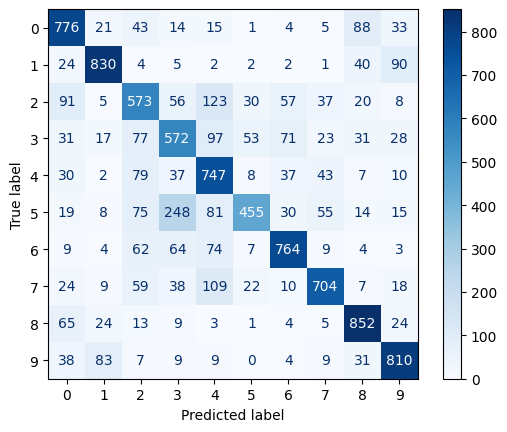

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labeled_y_true = [cifar10.labels[label_idx] for label_idx in y_true.tolist()]
labeled_y_pred = [cifar10.labels[label_idx] for label_idx in y_pred.tolist()]
conf_matrix = confusion_matrix(labeled_y_true, labeled_y_pred, labels=np.array(cifar10.labels))
display = ConfusionMatrixDisplay(conf_matrix)
display.plot(cmap=plt.cm.Blues)
plt.show()